In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
class NCAModel(nn.Module):
    def __init__(self, channel_n=16, fire_rate=0.5):
        super(NCAModel, self).__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate

        self.conv1 = nn.Conv2d(channel_n * 3, 128, kernel_size=1)
        self.conv2 = nn.Conv2d(128, channel_n, kernel_size=1)
    
    def perceive(self, x, device):
        """Perceive the neighboring cells."""
        kernel = torch.tensor([
            [[0.0, 1.0, 0.0],
             [1.0, 0.0, 1.0],
             [0.0, 1.0, 0.0]],
            [[1.0, 1.0, 1.0],
             [1.0, 0.0, 1.0],
             [1.0, 1.0, 1.0]],
            [[0.0, -1.0, 0.0],
             [-1.0, 0.0, -1.0],
             [0.0, -1.0, 0.0]]
        ]).to(device)
        kernel = kernel.unsqueeze(1).expand(-1, self.channel_n, -1, -1)
        y = F.conv2d(x, kernel, padding=1, groups=self.channel_n)
        return y

    def forward(self, x, device):
        y = self.perceive(x, device)
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv1(x))
        dx = self.conv2(x)
        stochastic_mask = (torch.rand(dx.shape[0], 1, dx.shape[2], dx.shape[3]) > self.fire_rate).to(device)
        dx = dx * stochastic_mask
        return dx

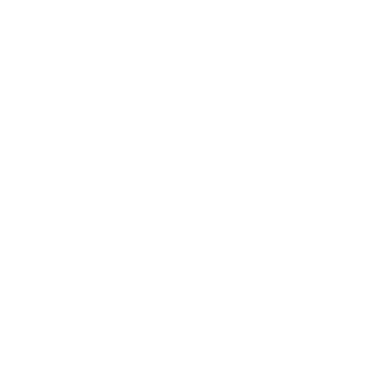

In [ ]:
from PIL import Image
import os
import numpy as np

def load_target_image(path, size):
    img = Image.open(path)
    img = img.resize((size, size))
    img = np.array(img) / 255.0
    return img

dir_path = os.path.abspath("")
target_img = load_target_image(f'{dir_path}/texture.png', 64)

plt.imshow(target_img)
plt.axis('off')
plt.show()





In [13]:
target = torch.from_numpy(target_img).permute(2, 0, 1).unsqueeze(0).float()

def train_nca(model, target, device, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    # Initialize the grid
    grid_size = target.shape[-1]
    x = torch.zeros(1, model.channel_n, grid_size, grid_size).to(device)
    x[:, :4, grid_size//2, grid_size//2] = 1.0  # Seed in the center
    
    losses = []
    
    for epoch in range(epochs):
        x.requires_grad_(True)
        dx = model(x, device)
        x = x + dx
        x = torch.clamp(x, 0.0, 1.0)
        
        loss = loss_fn(x[:, :4, :, :], target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return x, losses


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = NCAModel(channel_n=16, fire_rate=0.5).to(device)
trained_x, losses = train_nca(model, target, device, epochs=1000, lr=1e-3)


Using device: cuda


RuntimeError: Given groups=16, expected weight to be at least 16 at dimension 0, but got weight of size [3, 16, 3, 3] instead